In [1]:
import os
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Image Preprocessing and Augmentation Transforms

In [2]:
# Image preprocessing tranformation
import numpy as np
from skimage.filters.rank import enhance_contrast
from skimage import feature, io, img_as_ubyte
from skimage.morphology import disk

def ceed_canny(image):
    im = io.imread(image)
    enh = enhance_contrast(im, disk(1))
    edges = feature.canny(enh)
    final = img_as_ubyte(edges)
    return final

In [3]:
train_transformer = transforms.Compose([transforms.RandomApply([
        transforms.RandomRotation(10, fill=(0,))
        ],0.7)
  ])

# Custom Dataset Object

> One object to handle all cases! Depends on the input parameters, it can be train, test, validation set, handling Normal-Infected or Covid-NonCovid, turn on pre-processing or turn off

In [4]:
# Custom Lungs Dataset that can be constructed into Train, Test, Validation dataset respectively, and select a Dataset (Normal-Infected or Covid-NonCovid) to use, based on the binary classifier implementation.
class LungDataset(Dataset):
    def __init__(self, group, mode=0, preprocessing=False):

        # Select the mode for Dataset
        if mode not in [0, 1]:
            raise ValueError("Please input a mode as integers: 0: [Normal-Infected], 1: [Covid-NonCovid]")
            
        self.mode = mode

        self.img_size = (150, 150)
        
        self.class_names = ['normal', 'infected'] if mode == 0 else ['covid', 'non-covid']
        self.classes = {0: 'normal', 1: 'infected_covid', 2: 'infected_non_covid'}
        
        self.groups = [group]
        
        self.preprocessing = preprocessing
        
        # Number of images in each part of the dataset
        self.dataset_numbers = {'train_normal': 1341,\
                                'train_infected_covid': 1345,\
                                'train_infected_non_covid': 2530,\
                                'val_normal': 8,\
                                'val_infected_covid': 9,\
                                'val_infected_non_covid': 8,\
                                'test_normal': 234,\
                                'test_infected_covid': 139,\
                                'test_infected_non_covid': 242}
        
    def get_dataset_path(self, _class):
        sub_path = None
        group = self.groups[0]
        if _class == self.classes[1]:
            sub_path = os.path.join("infected", "covid")
        elif _class == self.classes[2]:
            sub_path = os.path.join("infected", "non-covid")
        else:
            sub_path = "normal"
        return os.path.join("dataset", group, sub_path)

    def filter_dataset_numbers(self):
        filtered_dataset_numbers_map = dict()
        for key, value in self.dataset_numbers.items():
            if self.groups[0] in key:
                filtered_dataset_numbers_map[key] = value
        return filtered_dataset_numbers_map

    def describe(self):
        if self.mode == 0:
            mode_str = "Normal-Infected"
        elif self.mode == 1:
            mode_str = "Covid-NonCovid"
        filtered_dataset_numbers_map = self.filter_dataset_numbers()
        # Generate description
        msg = "This is the Lung {} {} Dataset used for the Small Project Demo in the 50.039 Deep Learning class".format(self.groups[0].upper(), mode_str)
        msg += " in Feb-March 2021. \n"
        msg += "It contains a total of {} images, ".format(len(self))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "Images have been split in three groups: training, testing and validation sets.\n"
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for group in self.groups:
            for _class in self.classes.values():
                label = "{}_{}".format(group, _class)
                path = self.get_dataset_path(_class)
                if self.mode == 1 and "normal" not in _class:
                    msg += " - {}, in folder {}: {} images.\n".format(label, path, filtered_dataset_numbers_map[label])
                elif self.mode == 0:
                    msg += " - {}, in folder {}: {} images.\n".format(label, path, filtered_dataset_numbers_map[label])
        print(msg)
    
    def open_img(self, _class, index):
        group = self.groups[0]
        if _class not in self.classes.values():
            raise ValueError("Input class not found! Please input: {}. Got: {}".format(list(self.classes.values()), _class))
        max_val = self.dataset_numbers['{}_{}'.format(group, _class)]
        if index < 0 or index >= max_val:
            raise ValueError("Index out of range! Should be (0 ~ {}) but got {}".format(max_val-1, index))
        path_to_file = os.path.join(self.get_dataset_path(_class), "{}.jpg".format(index))
        imgs = []
        with open(path_to_file, 'rb') as f:
            if self.preprocessing:
                img = torch.from_numpy(ceed_canny(path_to_file))
                img = transforms.ToPILImage()(img)
            else:
                img = Image.open(f)
            if self.groups[0] == "train":
                for _ in range(2):
                    img_Temp = img
                    for _ in range(5):
                        img_Temp = train_transformer(img_Temp)
                        image = np.asarray(img_Temp) / 255
                        image = transforms.functional.to_tensor(np.array(image)).float()
                        imgs.append(image)
            else:
                image = np.asarray(img) / 255
                image = transforms.functional.to_tensor(np.array(image)).float()
                imgs.append(image)
        f.close()
        return imgs
    
    def show_img(self, _class, index):
        # Open image
        im = self.open_img(_class, index)
        
        # Display
        plt.imshow(im)

    def __len__(self):
        length = 0
        for key, item in self.dataset_numbers.items():
            if self.groups[0] in key:
                if self.mode == 0:
                    length += item
                elif self.mode == 1 and "normal" not in key:
                    length += item
        return length

    def __getitem__(self, index):
        filtered_dataset_numbers_map = self.filter_dataset_numbers()
        if self.mode == 0:
            first_val = int(list(filtered_dataset_numbers_map.values())[0])
            second_val = int(list(filtered_dataset_numbers_map.values())[1])
            if index < first_val:
                _class = 'normal'
                label = 0
            elif first_val <= index < first_val + second_val:
                _class = 'infected_covid'
                index = index - first_val
                label = 1
            else:
                _class = 'infected_non_covid'
                index = index - first_val - second_val
                label = 1
        elif self.mode == 1:
            first_val = int(list(filtered_dataset_numbers_map.values())[1])
            if index < first_val:
                _class = 'infected_covid'
                label = 0
            else:
                _class = 'infected_non_covid'
                index = index - first_val
                label = 1
        imgs = self.open_img(_class, index)
        return imgs, label

# Code to get Dataset for Normal-Infected binary set

In [5]:
trainset_NI = LungDataset(group="train", mode=0, preprocessing=True)
testset_NI = LungDataset(group="test", mode=0, preprocessing=True)
valset_NI = LungDataset(group="val", mode=0, preprocessing=True)

train_loader_NI = DataLoader(trainset_NI, batch_size=64, shuffle=True)
test_loader_NI = DataLoader(testset_NI, batch_size=64, shuffle=True)
val_loader_NI = DataLoader(valset_NI, batch_size=64, shuffle=True)

print(train_loader_NI, test_loader_NI, val_loader_NI)
print(len(train_loader_NI.dataset), len(test_loader_NI.dataset), len(val_loader_NI.dataset))

train_loader_NI.dataset.describe()
test_loader_NI.dataset.describe()
val_loader_NI.dataset.describe()

<torch.utils.data.dataloader.DataLoader object at 0x7f637ad8e0f0> <torch.utils.data.dataloader.DataLoader object at 0x7f637ad8e128> <torch.utils.data.dataloader.DataLoader object at 0x7f637ad8e208>
5216 615 25
This is the Lung TRAIN Normal-Infected Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 5216 images, of size 150 by 150.
Images have been split in three groups: training, testing and validation sets.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder dataset/train/normal: 1341 images.
 - train_infected_covid, in folder dataset/train/infected/covid: 1345 images.
 - train_infected_non_covid, in folder dataset/train/infected/non-covid: 2530 images.

This is the Lung TEST Normal-Infected Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 615 images, of size 150 by 150.
Image

# Code to get Dataset for Covid-NonCovid binary set

In [6]:
trainset_CN = LungDataset(group="train", mode=1, preprocessing=True)
testset_CN = LungDataset(group="test", mode=1, preprocessing=True)
valset_CN = LungDataset(group="val", mode=1, preprocessing=True)

train_loader_CN = DataLoader(trainset_CN, batch_size=64, shuffle=True)
test_loader_CN = DataLoader(testset_CN, batch_size=64, shuffle=True)
val_loader_CN = DataLoader(valset_CN, batch_size=64, shuffle=True)

print(train_loader_CN, test_loader_CN, val_loader_CN)
print(len(train_loader_CN.dataset), len(test_loader_CN.dataset), len(val_loader_CN.dataset))

train_loader_CN.dataset.describe()
test_loader_CN.dataset.describe()
val_loader_CN.dataset.describe()

<torch.utils.data.dataloader.DataLoader object at 0x7f637ad8e320> <torch.utils.data.dataloader.DataLoader object at 0x7f637ad8e668> <torch.utils.data.dataloader.DataLoader object at 0x7f637ad8e6a0>
3875 381 17
This is the Lung TRAIN Covid-NonCovid Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 3875 images, of size 150 by 150.
Images have been split in three groups: training, testing and validation sets.
The images are stored in the following locations and each one contains the following number of images:
 - train_infected_covid, in folder dataset/train/infected/covid: 1345 images.
 - train_infected_non_covid, in folder dataset/train/infected/non-covid: 2530 images.

This is the Lung TEST Covid-NonCovid Dataset used for the Small Project Demo in the 50.039 Deep Learning class in Feb-March 2021. 
It contains a total of 381 images, of size 150 by 150.
Images have been split in three groups: training, testing and validat

# Our Model

In [7]:
class Model(nn.Module):
    def __init__(self, dropout=0.2):
        super().__init__()

        self.dropout = dropout
        self.conv2d_2_1 = nn.Conv2d(1, 20, 5)
        self.conv2d_2_2 = nn.Conv2d(20, 50, 5)
        self.maxPool2d_2 = nn.MaxPool2d(kernel_size=3, stride=2, dilation=1)
        self.linear_2_1 = nn.Linear(50 * 33 * 33, 500)
        self.linear_2_4 = nn.Linear(500, 2)
    
        self.dropout = nn.Dropout(self.dropout)
        self.adaptiveAvgPool = nn.AdaptiveAvgPool2d(7)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x:torch.Tensor):
        x = F.relu(self.conv2d_2_1(x))
        x = self.maxPool2d_2(x)
        x = F.relu(self.conv2d_2_2(x))
        x = self.maxPool2d_2(x)
        x = self.dropout(x)

        x = x.view(x.size(0), -1)

        # Classifier
        x = F.relu(self.linear_2_1(x))
        x = self.dropout(x)
        x = F.relu(self.linear_2_4(x))
        return x

# Code for Training

In [8]:
model = Model()

# IMPORTANT! Supply mode -- 0: Normal-Infected 1: Covid-NonCovid
mode = 1

if mode == 0:
    train_loader = train_loader_NI
    test_loader = test_loader_NI
    val_loader = val_loader_NI
elif mode == 1:
    train_loader = train_loader_CN
    test_loader = test_loader_CN
    val_loader = val_loader_CN
else:
    print("Mode can only be 0 or 1!")
    sys.exit(1)

# Filenames to save
model_name = "small_project_model_binary_cn_preprocessed_1.pth"
train_loss_filename = "binary_cn_trainloss_preprocessed_1"
val_loss_filename = "binary_cn_valloss_preprocessed_1"
accuracy_filename = "binary_cn_acc_preprocessed_1"

# Check if trained model existed, if yes load it
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))


model.cuda()
criterion = torch.nn.CrossEntropyLoss()

lr = 3e-5

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def save_model(model):
    torch.save(model.state_dict(), model_name)

def train(epochs):

    n_epochs = epochs

    start = time.time()

    best_accuracy = 0

    for epoch in range(1, n_epochs + 1):

        train_loss = 0
        steps = 0

        # Training
        model.train()
        for datas, target in train_loader:
            for data in datas:
              data, tmp_target = data.cuda(), target.cuda()
              optimizer.zero_grad()
              output = model.forward(data)
              loss = criterion(output, tmp_target)
              loss.backward()
              optimizer.step()

              train_loss += loss.item()

              if steps % 40 == 0:
                accuracy = 0

                # Evaluation
                valid_loss = 0
                model.eval()
                for val_step, (data, val_target) in enumerate(test_loader):
                
                    data, tmp_target = data[0].cuda(), val_target.cuda()
                    val_output = model.forward(data)
                    loss = criterion(val_output, tmp_target)
                    valid_loss += loss.item()

                    _, preds = torch.max(val_output, 1)
                    accuracy += sum((preds == tmp_target).cpu().numpy())

                valid_loss /= (val_step + 1)
                accuracy = accuracy / len(test_loader.dataset)
                train_loss /= (steps + 1)
                
                print("Epoch: {:3}/{:3} Steps: {:4}/{:4} Train Loss: {:.6f} Validation Loss: {:.6f} Accuracy: {:.4f}".format(epoch, n_epochs, steps, len(train_loader)*10, train_loss, valid_loss, accuracy))

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    save_model(model)

                write_val_to_csv(valid_loss, val_loss_filename)
                write_val_to_csv(accuracy, accuracy_filename)
                write_val_to_csv(train_loss, train_loss_filename)
                
                model.train()

                if accuracy >= 0.98:
                    print('Performance condition satisfied, stopping..')
                    save_model(model)
                    print("Run time: {:.3f} min".format((time.time() - start)/60))
                    return train_loss_list, validation_loss_list, accuracy_list

              steps += 1   
            
    print("Run time: {:.3f} min".format((time.time() - start)/60))

# Helper Functions to Visualize Predictions

In [23]:
def show_images(images, labels, preds):
    class_names = train_loader.dataset.class_names
    plt.figure(figsize=(32, 16))
    for i, image in enumerate(images):
        plt.subplot(8, 8, i + 1, xticks=[], yticks=[])
        plt.imshow(np.squeeze(image))
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
        plt.rc('axes', labelsize=14)
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

def show_preds(model):
    model.eval()
    images, labels = next(iter(test_loader))
    images = images[0].to("cuda")
    labels = labels.to("cuda")
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())

# Helpfer Function to write values to CSV

In [10]:
def write_val_to_csv(val, name):
    
    with open("{}.csv".format(name), "a", encoding="utf-8") as fh:
        fh.write("{}\n".format(val))
    fh.close()


In [11]:
train(20)

Epoch:   1/ 20 Steps:    0/ 610 Train Loss: 0.690468 Validation Loss: 0.659863 Accuracy: 0.6352
Epoch:   1/ 20 Steps:   40/ 610 Train Loss: 0.618273 Validation Loss: 0.607544 Accuracy: 0.6352
Epoch:   1/ 20 Steps:   80/ 610 Train Loss: 0.309302 Validation Loss: 0.577484 Accuracy: 0.6929
Epoch:   1/ 20 Steps:  120/ 610 Train Loss: 0.205028 Validation Loss: 0.571808 Accuracy: 0.6457
Epoch:   1/ 20 Steps:  160/ 610 Train Loss: 0.149815 Validation Loss: 0.560243 Accuracy: 0.7664
Epoch:   1/ 20 Steps:  200/ 610 Train Loss: 0.118125 Validation Loss: 0.530750 Accuracy: 0.7428
Epoch:   1/ 20 Steps:  240/ 610 Train Loss: 0.098715 Validation Loss: 0.535814 Accuracy: 0.7165
Epoch:   1/ 20 Steps:  280/ 610 Train Loss: 0.087354 Validation Loss: 0.530270 Accuracy: 0.7218
Epoch:   1/ 20 Steps:  320/ 610 Train Loss: 0.077435 Validation Loss: 0.627890 Accuracy: 0.7795
Epoch:   1/ 20 Steps:  360/ 610 Train Loss: 0.064402 Validation Loss: 0.526751 Accuracy: 0.7743
Epoch:   1/ 20 Steps:  400/ 610 Train Lo

Epoch:   6/ 20 Steps:  240/ 610 Train Loss: 0.077186 Validation Loss: 0.399314 Accuracy: 0.8530
Epoch:   6/ 20 Steps:  280/ 610 Train Loss: 0.064624 Validation Loss: 0.402936 Accuracy: 0.8504
Epoch:   6/ 20 Steps:  320/ 610 Train Loss: 0.051248 Validation Loss: 0.365419 Accuracy: 0.8714
Epoch:   6/ 20 Steps:  360/ 610 Train Loss: 0.055169 Validation Loss: 0.390661 Accuracy: 0.8583
Epoch:   6/ 20 Steps:  400/ 610 Train Loss: 0.042738 Validation Loss: 0.374251 Accuracy: 0.8688
Epoch:   6/ 20 Steps:  440/ 610 Train Loss: 0.044074 Validation Loss: 0.415134 Accuracy: 0.8530
Epoch:   6/ 20 Steps:  480/ 610 Train Loss: 0.033605 Validation Loss: 0.495261 Accuracy: 0.8031
Epoch:   6/ 20 Steps:  520/ 610 Train Loss: 0.034113 Validation Loss: 0.478186 Accuracy: 0.8110
Epoch:   6/ 20 Steps:  560/ 610 Train Loss: 0.033022 Validation Loss: 0.378348 Accuracy: 0.8688
Epoch:   6/ 20 Steps:  600/ 610 Train Loss: 0.028091 Validation Loss: 0.379127 Accuracy: 0.8556
Epoch:   7/ 20 Steps:    0/ 610 Train Lo

KeyboardInterrupt: 

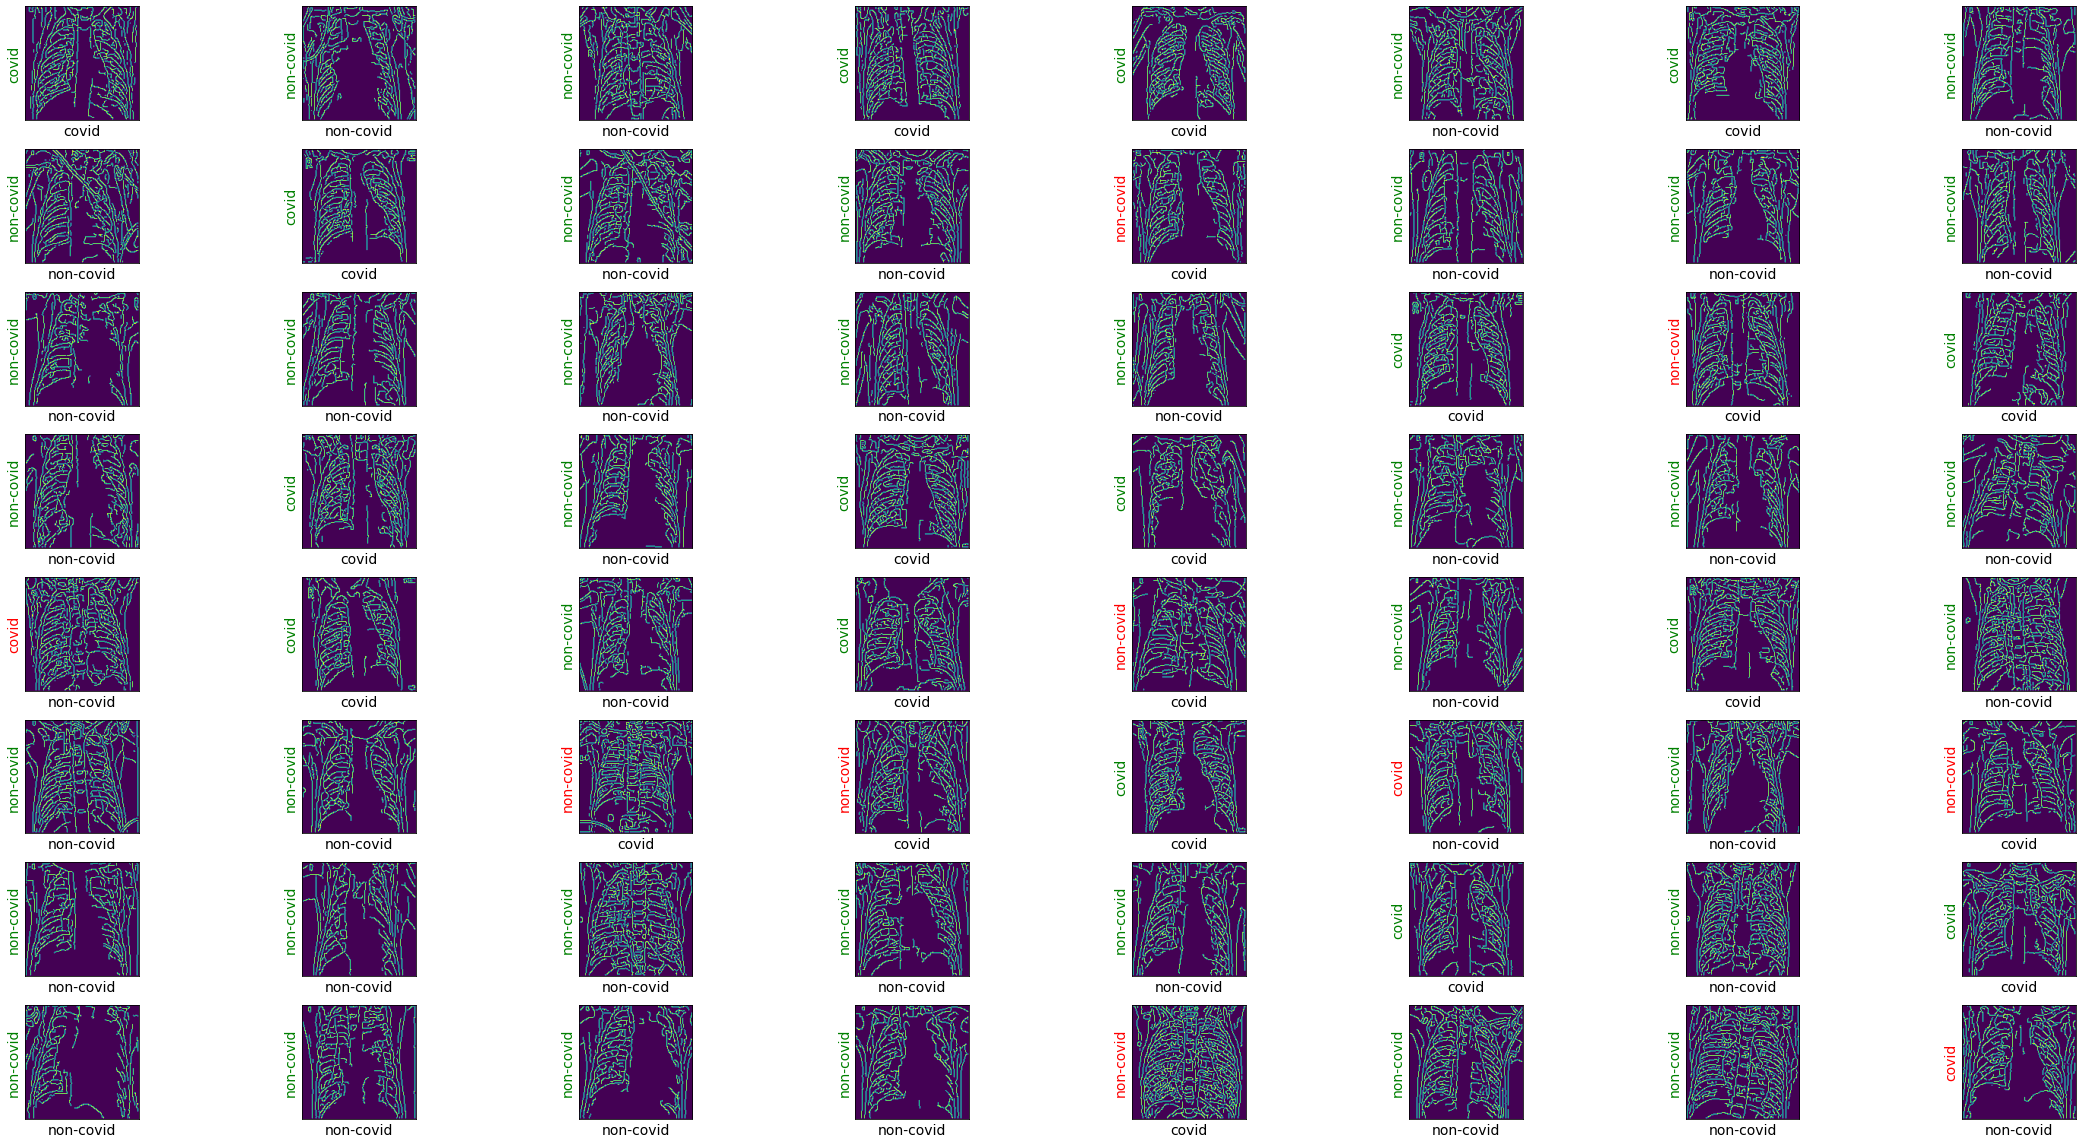

In [24]:
model = Model()
model.cuda()

if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))

show_preds(model)

# Test the image Augmentation

In [ ]:
images, labels = train_loader.dataset[123]
labels = [labels for _ in range(len(images))]

plt.figure(figsize=(16, 8))
for i, image in enumerate(images):
    plt.subplot(1, 10, i + 1, xticks=[], yticks=[])
    plt.imshow(np.squeeze(image))
    col = 'green'
    plt.rc('axes', labelsize=14)
    plt.xlabel(f'{train_loader.dataset.class_names[int(labels[i])]}')
plt.tight_layout()
plt.show()

# Read CSV for data recorded

In [26]:
def retrieve_data(csv_path):
    val_list = []
    with open(csv_path, "r", encoding="utf-8") as fh:
        lines = fh.readlines()
        for line in lines:
            line = line.strip("\n")
            if len(line) > 0:
                val_list.append(float(line))
    return val_list

# Plot Graph for Accuracy

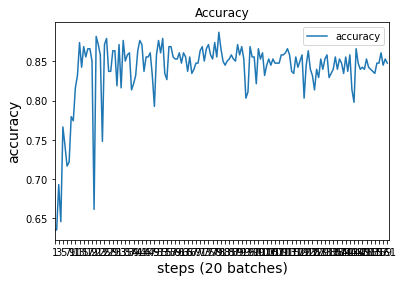

In [27]:
# Plotting accuracy
import matplotlib.pyplot as plt

accuracy_list = retrieve_data(accuracy_filename + ".csv")
steps = len(accuracy_list)
plt.plot(np.arange(1, steps+1,1),accuracy_list[:steps], label='accuracy')
plt.xticks(range(1,steps+1,2))
plt.xlim(1,steps+1)
plt.xlabel('steps (20 batches)')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend(loc='upper right')
filename = accuracy_filename + ".png"
plt.savefig(filename)
plt.show()

# Plot Graph for Train, Validation Loss

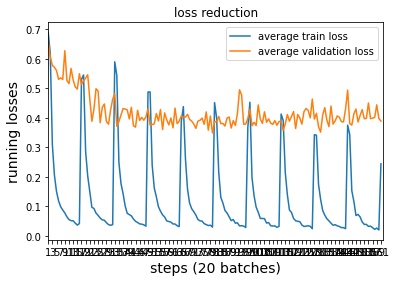

In [28]:
import matplotlib.pyplot as plt

train_loss_list = retrieve_data(train_loss_filename+".csv")
validation_loss_list = retrieve_data(val_loss_filename+".csv")
steps = len(validation_loss_list)
plt.plot(np.arange(1, steps+1,1),train_loss_list[:steps], label='average train loss')
plt.plot(np.arange(1,steps+1,1), validation_loss_list[:steps], label='average validation loss')
plt.xticks(range(1,steps+1,2))
plt.xlim(1,steps+1)
plt.xlabel('steps (20 batches)')
plt.ylabel('running losses')
plt.title('loss reduction')
plt.legend(loc='upper right')
filename = 'loss_profile_binary_cn_5.png'
plt.savefig(filename)
plt.show()